## 1. Make classification data using make_circles

Let's begin by making some data.

We'll use the [`make_moons()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) method from Scikit-Learn to make two interleaving half circles.

In [1]:
from sklearn.datasets import make_circles


# Make 2000 samples 
n_samples = 2000

# Create circles
X, y = make_circles(n_samples, 
                  noise=0.035, # a little bit of noise to the dots
                  random_state=20) # keep random state so we get the same values

In [2]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[-0.79117216 -0.32729477]
 [-0.71528534 -0.32698879]
 [-0.76081084 -0.23318453]
 [-0.65144472 -0.48797969]
 [ 0.78274017 -0.54688369]]

First 5 y labels:
[1 1 1 1 0]


In [3]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head(10)

,X1,X2,label
0,-0.791172,-0.327295,1
1,-0.715285,-0.326989,1
2,-0.760811,-0.233185,1
3,-0.651445,-0.487980,1
4,0.782740,-0.546884,0
5,-0.352068,0.987438,0
6,-0.531090,0.577630,1
7,-0.624389,-0.496376,1
8,-0.564922,-0.595216,1
9,-0.853562,0.597848,0


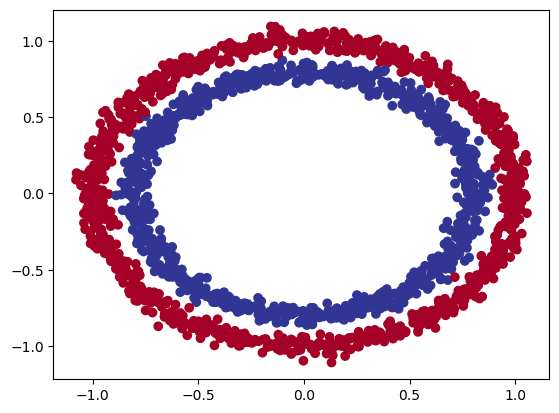

In [4]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);

In [5]:
# Turn data into tensors
# Otherwise this causes issues with computations later on
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[-0.7912, -0.3273],
         [-0.7153, -0.3270],
         [-0.7608, -0.2332],
         [-0.6514, -0.4880],
         [ 0.7827, -0.5469]]),
 tensor([1., 1., 1., 1., 0.]))

In [6]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(1600, 400, 1600, 400)

In [7]:
# Standard PyTorch imports
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [8]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), 
                            lr=0.1)

NameError: name 'model_0' is not defined

Now let's also create an **evaluation metric**.




In [16]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

##  Train model

Steps in training:

<details>
    <summary>PyTorch training loop steps</summary>
    <ol>
        <li><b>Forward pass</b> - The model goes through all of the training data once, performing its
            <code>forward()</code> function
            calculations (<code>model(x_train)</code>).
        </li>
        <li><b>Calculate the loss</b> - The model's outputs (predictions) are compared to the ground truth and evaluated
            to see how
            wrong they are (<code>loss = loss_fn(y_pred, y_train</code>).</li>
        <li><b>Zero gradients</b> - The optimizers gradients are set to zero (they are accumulated by default) so they
            can be
            recalculated for the specific training step (<code>optimizer.zero_grad()</code>).</li>
        <li><b>Perform backpropagation on the loss</b> - Computes the gradient of the loss with respect for every model
            parameter to
            be updated (each parameter
            with <code>requires_grad=True</code>). This is known as <b>backpropagation</b>, hence "backwards"
            (<code>loss.backward()</code>).</li>
        <li><b>Step the optimizer (gradient descent)</b> - Update the parameters with <code>requires_grad=True</code>
            with respect to the loss
            gradients in order to improve them (<code>optimizer.step()</code>).</li>
    </ol>
</details>



###  Going from raw model outputs to predicted labels (logits -> prediction probabilities -> prediction labels)


In [17]:
import numpy as np

# Plot linear data or training and test and predictions (optional)
def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})


def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(
        np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


In [18]:
# Build model with non-linear activation function
from torch import nn


class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=50)
       # self.layer_2 = nn.Linear(in_features=10, out_features=5)
        self.layer_3 = nn.Linear(in_features=50, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        self.sigmoid = nn.Sigmoid()# <- add in Sigmoid activation function
        self.Tanh = nn.Tanh()# <- add in Tanh activation function
        self.LeakyReLU = nn.LeakyReLU()# <- add in LeakyReLU activation function
        # Can also put sigmoid in the model 
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the LeakyReLU and Tanh activation functions between layers
       return self.layer_3(self.LeakyReLU(self.layer_1(x)))
       # return self.layer_3(self.Tanh(self.layer_2(self.LeakyReLU(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=50, bias=True)
  (layer_3): Linear(in_features=50, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (Tanh): Tanh()
  (LeakyReLU): LeakyReLU(negative_slope=0.01)
)


In [19]:
# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

### Training a model with non-linearity


In [43]:
# Fit the model
torch.manual_seed(42)
epochs = 3000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

loss_Ar = [] 

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    
    #add result of loss to array
    loss_Ar.append(loss.item())
    
    
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")
        

Epoch: 0 | Loss: 0.02754, Accuracy: 99.88% | Test Loss: 0.02983, Test Accuracy: 100.00%
Epoch: 100 | Loss: 0.02713, Accuracy: 99.88% | Test Loss: 0.02941, Test Accuracy: 100.00%
Epoch: 200 | Loss: 0.02673, Accuracy: 99.88% | Test Loss: 0.02901, Test Accuracy: 100.00%
Epoch: 300 | Loss: 0.02634, Accuracy: 99.88% | Test Loss: 0.02863, Test Accuracy: 100.00%
Epoch: 400 | Loss: 0.02597, Accuracy: 99.88% | Test Loss: 0.02825, Test Accuracy: 100.00%
Epoch: 500 | Loss: 0.02561, Accuracy: 99.88% | Test Loss: 0.02789, Test Accuracy: 100.00%
Epoch: 600 | Loss: 0.02527, Accuracy: 99.88% | Test Loss: 0.02754, Test Accuracy: 100.00%
Epoch: 700 | Loss: 0.02493, Accuracy: 99.88% | Test Loss: 0.02720, Test Accuracy: 100.00%
Epoch: 800 | Loss: 0.02460, Accuracy: 99.88% | Test Loss: 0.02687, Test Accuracy: 100.00%
Epoch: 900 | Loss: 0.02429, Accuracy: 99.94% | Test Loss: 0.02655, Test Accuracy: 100.00%
Epoch: 1000 | Loss: 0.02398, Accuracy: 99.94% | Test Loss: 0.02624, Test Accuracy: 100.00%
Epoch: 1100

### Evaluating a model trained with non-linear activation functions


In [44]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 1., 0., 1., 0., 0., 1., 0., 0., 0.]),
 tensor([1., 1., 1., 1., 0., 0., 1., 1., 1., 0.]))

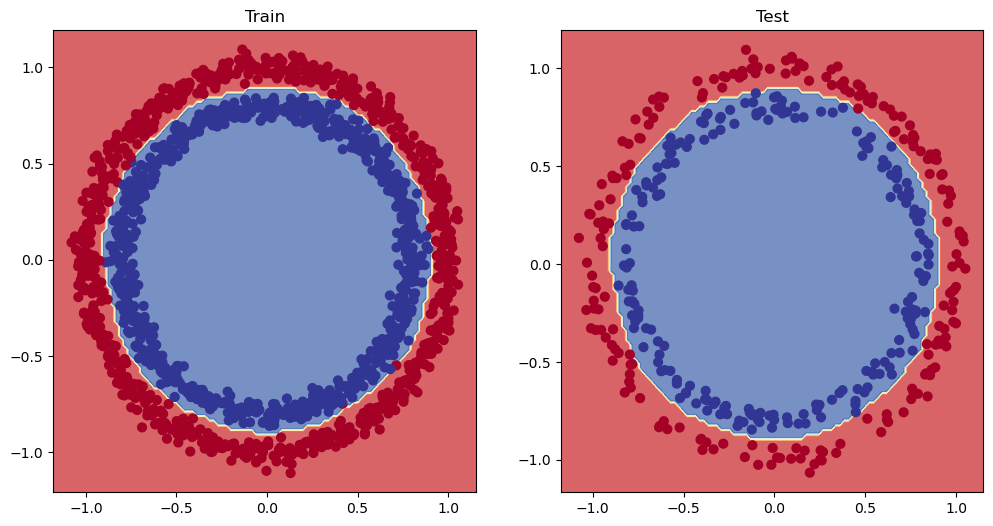

In [45]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

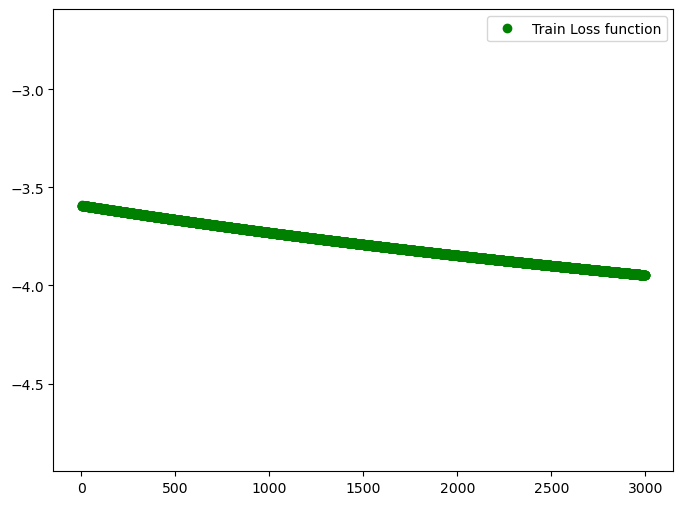

In [46]:
#print(np.log(loss_Ar))
num = [i for i in range(1, len(loss_Ar) + 1)]
#num_test = [i for i in range(1, len(loss_arr_test) + 1)]
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(num,  np.log(loss_Ar), "o", label="Train Loss function", color="green")
#ax.plot(num_test, loss_arr_test, "o", label="Test Loss function", color="red")
plt.ylim(min(np.log(loss_Ar)) - 1, max(np.log(loss_Ar)) + 1)
ax.legend(loc="best")
#plt.savefig("loss_arr_true.png")
plt.show()
plt.close('all')